<h3>Portfolio Optimisation Analysis</h3>
In this notebook I will be attempting to optimise my Vanguard ETF Portfolio using Modern Portfolio Theory (<a href="https://www.investopedia.com/terms/m/modernportfoliotheory.asp">MPT</a>); my portfolio currently consists of the following three ETFs:<br>
<table class="table table-bordered">
<tr>
<th scope="col">Ric</th>
<th scope="col">Name</th>
<th scope="col">% Weighting</th>
</tr>
<tr>
<td><a href="https://www.vanguardinvestor.co.uk/investments/vanguard-ftse-emerging-markets-ucits-etf-usd-distributing">VFEM.L</a></td>
<td>Vanguard FTSE Emerging Markets</td>
<td>10</td>
</tr>
<tr>
<td><a href="https://www.vanguardinvestor.co.uk/investments/vanguard-ftse-250-ucits-etf-gbp-distributing">VMID.L</a></td>
<td>Vanguard FTSE 250 UCITS</td>
<td>25</td>
</tr>
<tr>
<td><a href="https://www.vanguardinvestor.co.uk/investments/vanguard-ftse-all-world-ucits-etf-usd-distributing">VWRL.L</a></td>
<td>Vanguard FTSE All World</td>
<td>65</td>
</tr>
</table>
I will attempt to calculate the efficient frontier using 3 years of <a href="https://www.worldtradingdata.com/">World Trading Data</a>'s ETF price history and randomly generated Portfolios; this will help me find the most optimal ETF weightings which maximises my Risk vs Return (maximum <a href="https://www.investopedia.com/terms/s/sharperatio.asp">Sharpe Ratio</a>).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np

In [2]:
#Load in ETF price data into one dataframe with close prices and dates

vwrl_json = json.load(open('VWRL_Prices.json'))
vwrl_prices = pd.DataFrame.from_dict(vwrl_json.get('history'),orient='index').reset_index()
vwrl_prices.rename(columns={"index":"Date", "close":"VWRL"}, inplace=True)
vwrl_prices = vwrl_prices[["Date","VWRL"]]

vmid_json = json.load(open('VMID_Prices.json'))
vmid_prices = pd.DataFrame.from_dict(vmid_json.get('history'),orient='index').reset_index()
vmid_prices.rename(columns={"index":"Date","close":"VMID"}, inplace=True)
vmid_prices = vmid_prices[["Date","VMID"]]

vfem_json = json.load(open('VFEM_Prices.json'))
vfem_prices = pd.DataFrame.from_dict(vfem_json.get('history'),orient='index').reset_index()
vfem_prices.rename(columns={"index":"Date","close":"VFEM"}, inplace=True)
vfem_prices = vfem_prices[["Date","VFEM"]]

#Merge all etfs into one dataframe joined on Date
etfs = pd.merge(left=vwrl_prices, right=vmid_prices, left_on='Date', right_on='Date', how='inner')
etfs = pd.merge(left=etfs, right=vfem_prices, left_on='Date', right_on='Date', how='inner')

etfs = etfs.sort_values(by='Date',ascending=True)
etfs = etfs.set_index('Date')

print(etfs.dtypes)
print(etfs.head(5))

VWRL    object
VMID    object
VFEM    object
dtype: object
             VWRL   VMID   VFEM
Date                           
2017-03-03  60.46  30.42  42.35
2017-03-06  60.42  30.40  42.57
2017-03-07  60.65  30.42  42.87
2017-03-08  60.82  30.46  42.78
2017-03-09  60.66  30.47  42.17


In [3]:
#Convert prices from objects to floats
etfs['VFEM'] = pd.to_numeric(etfs['VFEM'])
etfs['VMID'] = pd.to_numeric(etfs['VMID'])
etfs['VWRL'] = pd.to_numeric(etfs['VWRL'])
print(etfs.dtypes)
print(etfs.head(5))

VWRL    float64
VMID    float64
VFEM    float64
dtype: object
             VWRL   VMID   VFEM
Date                           
2017-03-03  60.46  30.42  42.35
2017-03-06  60.42  30.40  42.57
2017-03-07  60.65  30.42  42.87
2017-03-08  60.82  30.46  42.78
2017-03-09  60.66  30.47  42.17


In [4]:
#Normalise the prices using logarithmic returns
etfs_log_rtn = np.log(etfs/etfs.shift(1))
print(etfs_log_rtn.head(5))

                VWRL      VMID      VFEM
Date                                    
2017-03-03       NaN       NaN       NaN
2017-03-06 -0.000662 -0.000658  0.005181
2017-03-07  0.003799  0.000658  0.007023
2017-03-08  0.002799  0.001314 -0.002102
2017-03-09 -0.002634  0.000328 -0.014362


<h3>Plotting the Efficient Frontier</h3>
Now that the price history for each ETF is formatted it is time to generate random weightings for each ETF in the portfolio (with the sum of the weightings equal to 1).<br> 
The expected return and volatility of each generated portfolio is calculated, along with the sharpe ratio, and plotted as a scatter graph; each portfolio sitting on the hyperbola that is formed reflects the highest return possible for that level of risk.

In [5]:
num_random_portfolios = 10000
num_etfs = len(etfs.columns)

#Initialise numpy arrays
all_weights = np.zeros((num_random_portfolios, num_etfs))
exp_rtns = np.zeros(num_random_portfolios) 
exp_vols = np.zeros(num_random_portfolios)
exp_sharpe_ratios = np.zeros(num_random_portfolios)

#Generate the random portfolios
for x in range(num_random_portfolios):
    
    # Generate random weights
    weights = np.array(np.random.random(num_etfs))
    weights = weights / np.sum(weights)
    
    # Save the random weights
    all_weights[x, :] = weights

    # Save expected annual returns
    exp_rtns[x] = np.sum((etfs_log_rtn.mean() * weights * 252))

    # Save expected volatilities
    exp_vols[x] = np.sqrt(np.dot(weights.T, np.dot(etfs_log_rtn.cov() * 252, weights)))

    # Save Sharpe Ratios
    exp_sharpe_ratios[x] = exp_rtns[x] / exp_vols[x]
    
#Calculate the expected return, volatility and sharpe ratio of the current portfolio
current_portfolio = np.array([0.65,0.25,0.10])
curr_rtn = np.sum((etfs_log_rtn.mean() * current_portfolio * 252))
curr_vol = np.sqrt(np.dot(current_portfolio.T, np.dot(etfs_log_rtn.cov() * 252, current_portfolio)))
curr_sharpe = curr_rtn / curr_vol

max_sharpe_ratio = exp_sharpe_ratios.max()
max_sharpe_loc = exp_sharpe_ratios.argmax()
max_sharpe_rtn = exp_rtns[max_sharpe_loc]
max_sharpe_vol = exp_vols[max_sharpe_loc]

print('Maximum Sharpe Ratio: ', max_sharpe_ratio)
print('Expected Return for max sharpe portfolio: ', max_sharpe_rtn)
print('Expected Volatility for max sharpe portfolio: ', max_sharpe_vol)

print('Current Portfolio Sharpe Ratio: ', curr_sharpe)
print('Expected Return for current portfolio: ', curr_rtn)
print('Expected Volatility for current portfolio: ', curr_vol)

Maximum Sharpe Ratio:  0.26761502534650905
Expected Return for max sharpe portfolio:  0.035542700873599585
Expected Volatility for max sharpe portfolio:  0.13281280013175176
Current Portfolio Sharpe Ratio:  0.19864043201180537
Expected Return for current portfolio:  0.02447351826228052
Expected Volatility for current portfolio:  0.12320511999705094


In [6]:
max_sharpe_portfolio = all_weights[max_sharpe_loc,:]
print('Max Sharpe Portfolio Weightings: ', max_sharpe_portfolio)

Max Sharpe Portfolio Weightings:  [9.82157349e-01 1.72014968e-02 6.41154584e-04]


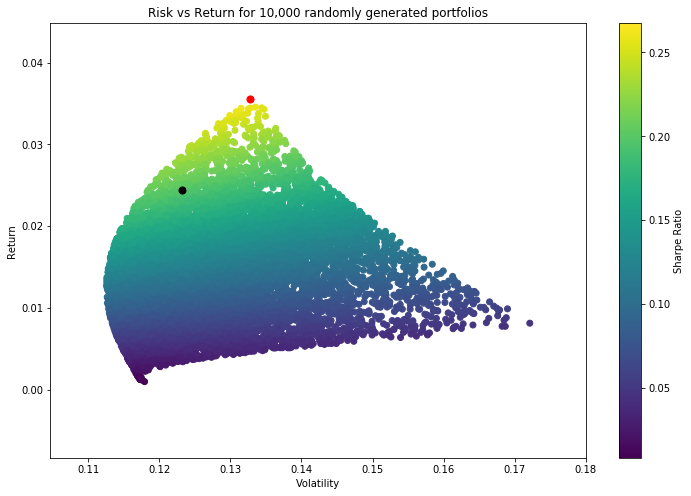

In [7]:
%matplotlib inline
plt.figure(figsize=(12,8))
plt.title('Risk vs Return for 10,000 randomly generated portfolios')
plt.scatter(exp_vols, exp_rtns, c=exp_sharpe_ratios, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sharpe_vol, max_sharpe_rtn,c='red', s=50) # red dot
plt.scatter(curr_vol, curr_rtn,c='black', s=50) # Black dot
plt.show()

<h3>Analysis</h3>
After generating 10,000 random portfolios the maximum sharpe ratio possible is 0.268 as seen by the red dot on the efficient frontier graph, my current portfolio is also plotted as a black dot.<br>
The portfolio has an expected annual return of 3.55% and an expected annual volatility of 13.28%.<br>
The max sharpe portfolio ETF weightings are:<br>
<table class="table table-bordered">
<tr>
<th scope="col">Ric</th>
<th scope="col">Name</th>
<th scope="col">% Weighting</th>
</tr>
<tr>
<td><a href="https://www.vanguardinvestor.co.uk/investments/vanguard-ftse-emerging-markets-ucits-etf-usd-distributing">VFEM.L</a></td>
<td>Vanguard FTSE Emerging Markets</td>
<td>0.0641154584</td>
</tr>
<tr>
<td><a href="https://www.vanguardinvestor.co.uk/investments/vanguard-ftse-250-ucits-etf-gbp-distributing">VMID.L</a></td>
<td>Vanguard FTSE 250 UCITS</td>
<td>1.72014968</td>
</tr>
<tr>
<td><a href="https://www.vanguardinvestor.co.uk/investments/vanguard-ftse-all-world-ucits-etf-usd-distributing">VWRL.L</a></td>
<td>Vanguard FTSE All World</td>
<td>98.2157349</td>
</tr>
</table>
<br>
To see how this portfolio would perform in the real world the next step is to back-test the portfolio and compare it to a benchmark such as my original portfolio; the <a href="https://github.com/mspstead/data-site/tree/data-site-first-branch/lambda%20functions/price_performance">portfolio performance API</a> I created can be used to do this analysis but it requires actual share amounts as inputs so these will need to be calculated first.

In [13]:
etfs_test = etfs.reset_index()
start_date = etfs_test.iloc[0,0]
end_date = etfs_test.iloc[-1,0]

#starting with a marketcap of 1000 GBP
market_cap = 1000 
start_prices = etfs_test[etfs_test['Date']==start_date]

#get share amounts of each etf in the maximum sharpe portfolio
shares_mx_sharpe = [(market_cap*max_sharpe_portfolio[w])/start_prices.iloc[0,w+1] for w in range(len(max_sharpe_portfolio))]

#get share amounts of each etf in the current benchmark portfolio
curr_portfolio = [0.65,0.25,0.10]
shares_benchmark = [(market_cap*curr_portfolio[w])/start_prices.iloc[0,w+1] for w in range(len(curr_portfolio))]

print('Start Date: ', start_date)
print('End Date: ', end_date)
print('Max Sharpe Ratio Shares VWRL, VMID, VFEM: ',shares_mx_sharpe)
print('Benchmark Shares VWRL, VMID, VFEM: ',shares_benchmark)


Start Date:  2017-03-03
End Date:  2020-03-02
Max Sharpe Ratio Shares VWRL, VMID, VFEM:  [16.244746090594795, 0.5654666922731812, 0.015139423463720113]
Benchmark Shares VWRL, VMID, VFEM:  [10.750909692358585, 8.21827744904668, 2.3612750885478158]


The API call requests take the following formats:<br>

Max Sharpe portfolio = {
    "BasketComposition": [
        {"Identifier": "VFEM.L","Shares":0.015139423463720113},
        {"Identifier": "VWRL.L","Shares":16.244746090594795},
        {"Identifier": "VMID.L","Shares":0.5654666922731812}
        ],
    "Currency": "GBP",
    "StartDate": "2017-03-03",
    "EndDate": "2020-03-02"
}

<br>Benchmark Portfolio = {
    "BasketComposition": [
        {"Identifier": "VFEM.L","Shares":2.3612750885478158},
        {"Identifier": "VWRL.L","Shares":10.750909692358585},
        {"Identifier": "VMID.L","Shares":8.21827744904668}
        ],
    "Currency": "GBP",
    "StartDate": "2017-03-03",
    "EndDate": "2020-03-02"
}

<br>The requests will be sent using postman and the results saved as json files current_portfolio_perf and max_sharpe_portfolio_perf.

In [16]:
curr_json = json.load(open('current_portfolio_perf.json'))
curr_perf = pd.DataFrame.from_dict(curr_json.get('BasketPerformance')).sort_values(by='Date')
curr_perf = curr_perf[['Date','Cumulative_Return','Daily_Return']]
curr_perf['Date'] = pd.to_datetime(curr_perf['Date'])
print('Current Portfolio:')
print(curr_perf.head(5))

Current Portfolio:
          Date  Cumulative_Return  Daily_Return
753 2017-03-03           0.000000      0.000000
752 2017-03-06          -0.007492     -0.007492
751 2017-03-07           0.327079      0.334571
750 2017-03-08           0.520832      0.193753
749 2017-03-09           0.214595     -0.306237


In [17]:
mx_sharpe_json = json.load(open('max_sharpe_perf.json'))
mx_sharpe_perf = pd.DataFrame.from_dict(mx_sharpe_json.get('BasketPerformance')).sort_values(by='Date')
mx_sharpe_perf = mx_sharpe_perf[['Date','Cumulative_Return','Daily_Return']]
mx_sharpe_perf['Date'] = pd.to_datetime(mx_sharpe_perf['Date'])
print('Maximum Sharpe Portfolio:')
print(mx_sharpe_perf.head(5))

Maximum Sharpe Portfolio:
          Date  Cumulative_Return  Daily_Return
753 2017-03-03           0.000000      0.000000
752 2017-03-06          -0.062770     -0.062770
751 2017-03-07           0.310590      0.373360
750 2017-03-08           0.583705      0.273115
749 2017-03-09           0.322495     -0.261210


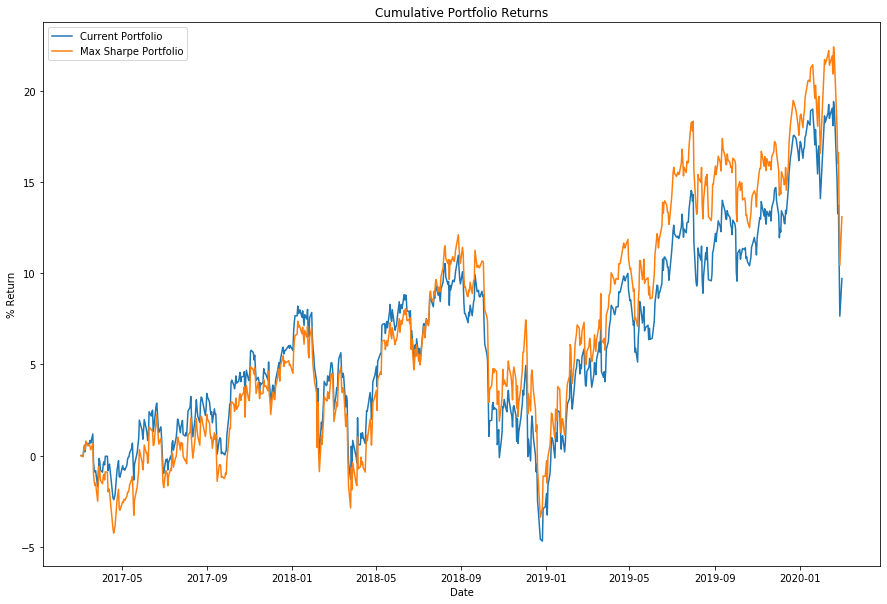

In [18]:
plt.figure(figsize=[15,10])
plt.plot(curr_perf['Date'],curr_perf['Cumulative_Return'],label='Current Portfolio')
plt.plot(mx_sharpe_perf['Date'],mx_sharpe_perf['Cumulative_Return'],label='Max Sharpe Portfolio')
plt.xlabel('Date')
plt.ylabel('% Return')
plt.title('Cumulative Portfolio Returns')
plt.xticks()
plt.legend()
plt.show()

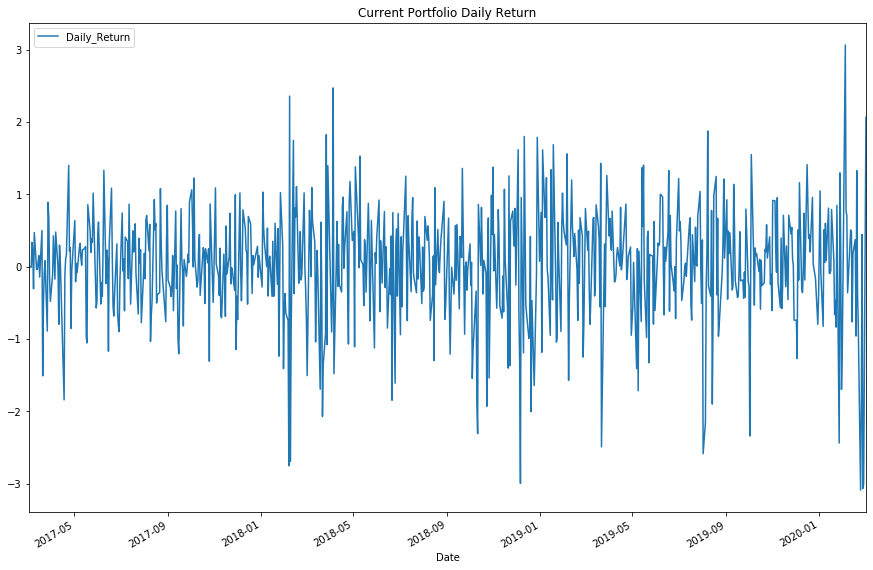

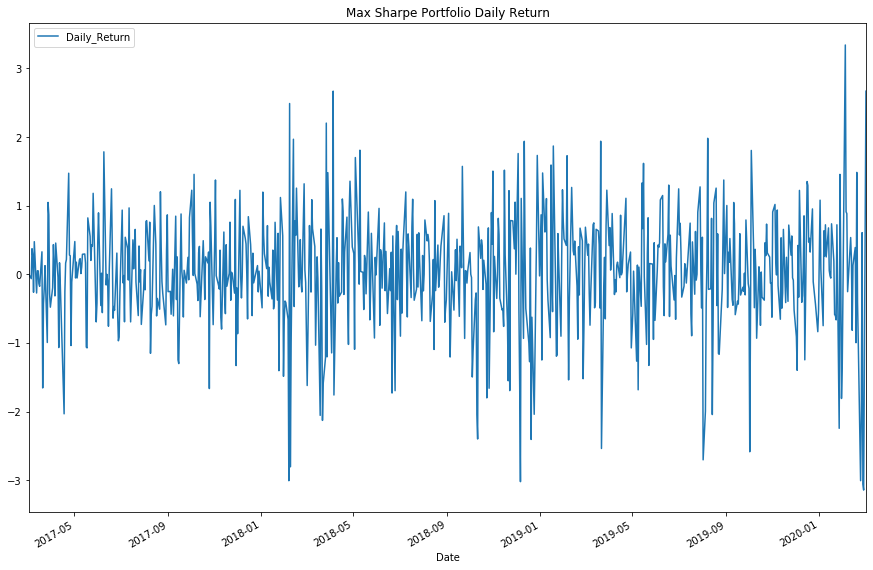

In [19]:
curr_perf.plot(x='Date',y='Daily_Return',title='Current Portfolio Daily Return',figsize=[15,10])
mx_sharpe_perf.plot(x='Date',y='Daily_Return',title='Max Sharpe Portfolio Daily Return',figsize=[15,10])
plt.show()

<h3>Final Analysis</h3>
As seen by the back testing results the maximum sharpe ratio portfolio found using MPT provides better returns at a similar risk profile to my current portfolio.<br>
The performance difference looks to be due to the heavy (98%) weighting towards the VWRL ETF which is primarily made up of US stocks (58% US stock ETF) which have performed well over recent years compared to other markets.<br>
My next step will be to try out the same process but to include a larger set of Vanguard ETFs to find other ETFs I should be including or excluding from my portfolio; I will also compare the results to some US equity only ETFs such as <a href="https://www.etf.com/SPY">SPY.P</a> to determine how big of an impact the US equity market has on the portfolio construction.